<a href="https://colab.research.google.com/github/geethanjalins/Fish-Project/blob/main/MulticlassFish.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data preprocess & Augmentation

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image dimensions
img_height = 128  # Example height, change as needed
img_width = 128   # Example width, change as needed

# Create a data generator with rescaling and augmentation
datagen = ImageDataGenerator(
    rescale=1./255,             # Rescale pixel values
    rotation_range=40,          # Random rotation between -40 to 40 degrees
    zoom_range=0.2,             # Random zoom
    horizontal_flip=True,       # Random horizontal flips
    vertical_flip=True          # Random vertical flips (optional)
)
# Fit generator to your dataset
train_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/images.cv_jzk6llhf18tm3k0kyttxz/dataSET/train',
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical'  # or 'binary' depending on your task
)

Found 2422 images belonging to 11 classes.


In [11]:
from tensorflow.keras.applications import VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

In [12]:
base_model.trainable = False

In [13]:
from tensorflow.keras import layers, models

x = base_model.output
x = layers.GlobalAveragePooling2D()(x) # Better than Flatten for pre-trained models
x = layers.Dense(1024, activation='relu')(x)
NUM_CLASSES = train_generator.num_classes # Define NUM_CLASSES from the training generator
predictions = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = models.Model(inputs=base_model.input, outputs=predictions)
print(NUM_CLASSES)


11


In [14]:
# Unfreeze the last few layers of the base model
base_model.trainable = True # Set base_model to trainable first
N_LAYERS_TO_UNFREEZE = 4 # Define the number of layers to unfreeze. Change this value as needed.
for layer in base_model.layers[:-N_LAYERS_TO_UNFREEZE]:
    layer.trainable = False

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16, ResNet50, MobileNet, InceptionV3, EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
import os
import pandas as pd

# --- 1. CONFIGURATION ---
# >>> IMPORTANT: Replace these with your actual values <<<
# Replace 'path/to/your/fish_dataset' with the actual path to the root of your dataset
DATASET_PATH = '/content/drive/MyDrive/images.cv_jzk6llhf18tm3k0kyttxz/dataSET'
IMAGE_SIZE = 224      # Standard size for VGG, ResNet, MobileNet
BATCH_SIZE = 32
EPOCHS_SCRATCH = 25   # More epochs for scratch model
EPOCHS_TRANSFER = 10  # Fewer epochs for transfer learning steps
BEST_MODEL_FILEPATH = 'best_fish_classifier_model.h5' # The final saved model name

# --- 2. DATA GENERATORS ---

# Use augmentation for training data to improve generalization
train_datagen = ImageDataGenerator(
    rescale=1./255, # Normalize
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Only normalization for validation data
validation_datagen = ImageDataGenerator(rescale=1./255)

try:
    train_generator = train_datagen.flow_from_directory(
        os.path.join(DATASET_PATH, 'train'),
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical'
    )
    validation_generator = validation_datagen.flow_from_directory(
        os.path.join(DATASET_PATH, 'validation'),
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical'
    )
except Exception as e:
    print(f"Error loading data: {e}. Please check DATASET_PATH and folder structure.")
    # Removed exit() to allow the cell to continue execution after printing the error
    # exit()

NUM_CLASSES = train_generator.num_classes

# --- 3. CALLBACKS for Saving the MAX Accuracy Model ---

# ModelCheckpoint saves the model with the highest 'val_accuracy'
checkpoint = ModelCheckpoint(
    filepath=BEST_MODEL_FILEPATH,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True, # This ensures only the highest accuracy model is saved
    verbose=1,
    # Removed save_format='h5' as it's not a valid argument
)

# EarlyStopping stops training if validation loss plateaus
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

results_list = []

Found 2422 images belonging to 11 classes.
Error loading data: [Errno 2] No such file or directory: '/content/drive/MyDrive/images.cv_jzk6llhf18tm3k0kyttxz/dataSET/validation'. Please check DATASET_PATH and folder structure.


#Model training

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image size (e.g., 224x224 for VGG16, ResNet50)
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 9 # Replace with the actual number of fish species

# Data Augmentation and Preprocessing
datagen = ImageDataGenerator(
    rescale=1./255, # Normalize pixel values
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2 # Use 20% for validation
)

# Load data from directory
train_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/images.cv_jzk6llhf18tm3k0kyttxz/dataSET/train', # **CHANGE THIS PATH**
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/images.cv_jzk6llhf18tm3k0kyttxz/dataSET/val', # **CHANGE THIS PATH**
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 1940 images belonging to 11 classes.
Found 215 images belonging to 11 classes.


#Train a CNN Model from Scratch

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Build the model
scratch_model = Sequential([
    # Convolutional Base
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Classifier Head
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax') # Output layer
])

# Compile the model
scratch_model.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

# Train the model
# history_scratch = scratch_model.fit(
#     train_generator,
#     epochs=20, # Adjust epochs based on convergence
#     validation_data=validation_generator
# )

# **After training, record the max validation accuracy.**

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#Experiment with and Fine-Tune Pre-trained Models

In [22]:
from tensorflow.keras.applications import VGG16, ResNet50, MobileNet, InceptionV3, EfficientNetB0
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam

# --- MODEL SELECTION ---
# Change to the model you are testing:
BASE_MODEL_NAME = "EfficientNetB0"
# Make sure your ImageDataGenerator target_size matches the model's required input size.
if BASE_MODEL_NAME == "VGG16":
    BaseModel = VGG16
    TARGET_SIZE = (224, 224)
elif BASE_MODEL_NAME == "ResNet50":
    BaseModel = ResNet50
    TARGET_SIZE = (224, 224)
elif BASE_MODEL_NAME == "MobileNet":
    BaseModel = MobileNet
    TARGET_SIZE = (224, 224)
elif BASE_MODEL_NAME == "InceptionV3":
    BaseModel = InceptionV3
    TARGET_SIZE = (299, 299)
elif BASE_MODEL_NAME == "EfficientNetB0":
    BaseModel = EfficientNetB0
    TARGET_SIZE = (224, 224)
else:
    raise ValueError("Invalid BASE_MODEL_NAME specified.")


# 1. Load the pre-trained base model
base_model = BaseModel(weights='imagenet',
                       include_top=False, # Exclude the final classification layer
                       input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3))

# 2. Freeze the base model layers
base_model.trainable = False

# 3. Create a new classification head (top layers)
x = base_model.output
x = GlobalAveragePooling2D()(x) # Reduces spatial dimensions to a feature vector
x = Dense(512, activation='relu')(x)
# Assuming NUM_CLASSES is defined in a previous cell (e.g., after data loading)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# 4. Assemble the new model
transfer_model = Model(inputs=base_model.input, outputs=predictions)

# 5. Compile the model (Phase 1: Train the new top layers)
transfer_model.compile(optimizer='adam',
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

# 6. Train the top layers (a few epochs is usually enough)
# history_transfer = transfer_model.fit(
#     train_generator,
#     epochs=5,
#     validation_data=validation_generator
# )

# 7. Fine-Tuning (Optional, but often improves results)
# Unfreeze the last few layers of the base model
# base_model.trainable = True
# fine_tune_at = 100 # Example: unfreeze from layer 100 onwards
# for layer in base_model.layers[:fine_tune_at]:
#     layer.trainable = False

# # Re-compile with a lower learning rate for fine-tuning
# transfer_model.compile(optimizer=Adam(learning_rate=1e-5),
#                        loss='categorical_crossentropy',
#                        metrics=['accuracy'])

# # Continue training for a few more epochs
# # history_fine_tune = transfer_model.fit(
# #     train_generator,
# # #    epochs=10, # More epochs for fine-tuning
# #     validation_data=validation_generator
# # )

# **After training and fine-tuning all five models, compare their max validation accuracies.**

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


#Save the Max Accuracy Model

In [24]:
# Assuming 'best_model' is the Keras Model object with the highest accuracy
BEST_MODEL_NAME = 'best_fish_classifier_model.h5'

# Save the full model
transfer_model.save(BEST_MODEL_NAME)

print(f"✅ Model successfully saved to {BEST_MODEL_NAME}")

✅ Model successfully saved to best_fish_classifier_model.h5


#Pickle

In [29]:
import pickle
# Saving the Keras model object directly is discouraged, but for non-DL models or specific ML workflows:
try:
    with open('best_fish_classifier_model.pkl', 'wb') as file:
        pickle.dump(BEST_MODEL_NAME, file)
    print("⚠️ Model saved using pickle (use .h5 for Keras where possible)")
except Exception as e:
    print(f"❌ Pickle failed for Keras model: {e}")

⚠️ Model saved using pickle (use .h5 for Keras where possible)


#Compare Classification Metrics

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 47s 7s/step
Classification Report for Transfer Model:
                                  precision    recall  f1-score   support

                     animal fish       0.00      0.00      0.00        37
                animal fish bass       0.00      0.00      0.00         2
   fish sea_food black_sea_sprat       0.00      0.00      0.00        21
   fish sea_food gilt_head_bream       0.08      1.00      0.15        18
   fish sea_food hourse_mackerel       0.00      0.00      0.00        19
        fish sea_food red_mullet       0.00      0.00      0.00        18
     fish sea_food red_sea_bream       0.00      0.00      0.00        22
          fish sea_food sea_bass       0.00      0.00      0.00        19
            fish sea_food shrimp       0.00      0.00      0.00        20
fish sea_food striped_red_mullet       0.00      0.00      0.00        20
             fish sea_food trout       0.00      0.00      0.00        19

                        accurac

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


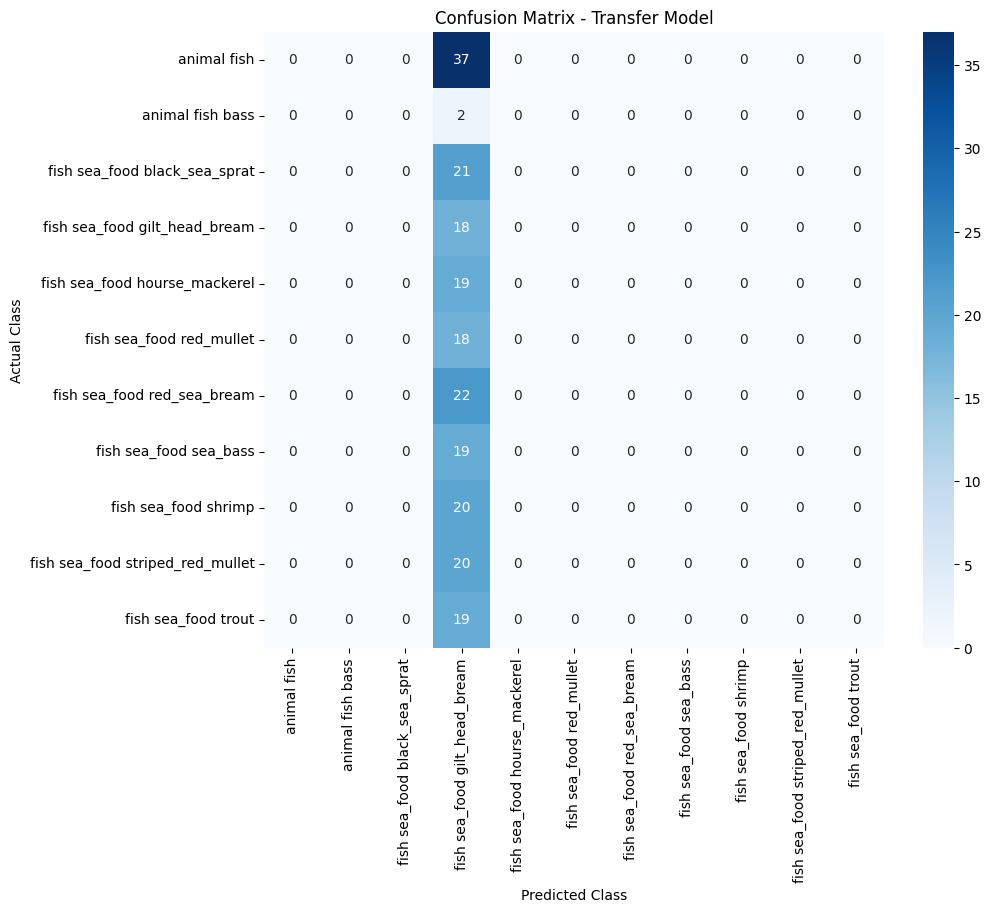

In [31]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assume you have a compiled and trained 'model' and a 'test_generator' (or test_data/labels)

# 1. Get True Labels and Predictions
# Reset the generator to ensure predictions start from the first image
validation_generator.reset()

# Predict the class probabilities
Y_pred = transfer_model.predict(validation_generator)

# Convert probabilities to class labels (index of the max probability)
y_pred = np.argmax(Y_pred, axis=1)

# Get the true class labels
y_true = validation_generator.classes

# Get the class names (important for the report)
class_names = list(validation_generator.class_indices.keys())

# 2. Print Classification Report
# Assuming 'model_name' is defined, otherwise replace it with a string like "Transfer Model"
model_name = "Transfer Model"
print(f"=================================================")
print(f"Classification Report for {model_name}:")
print(classification_report(y_true, y_pred, target_names=class_names))
print(f"=================================================\n")

# 3. Generate and Plot Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title(f'Confusion Matrix - {model_name}')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

# Store results in a comparison table
# You would collect the macro/weighted average metrics here for a final table
# Example: final_metrics[model_name] = classification_report(y_true, y_pred, output_dict=True)['weighted avg']

#Visualize Training History

In [39]:
import matplotlib.pyplot as plt

# Assume 'history' is the object returned by model.fit()
# and 'model_name' is a string identifier (e.g., "VGG16")

def plot_training_history(history, model_name):
    """Plots the training and validation accuracy and loss."""

    # 1. Plot Accuracy
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)

    # Keras uses 'accuracy' by default, but check keys if using older Keras/TensorFlow
    if 'accuracy' in history.history:
        acc_key = 'accuracy'
        val_acc_key = 'val_accuracy'
    else:
        acc_key = 'acc'
        val_acc_key = 'val_acc'

    plt.plot(history.history[acc_key], label='Training Accuracy')
    plt.plot(history.history[val_acc_key], label='Validation Accuracy')
    plt.title(f'{model_name} - Training vs. Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # 2. Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Training vs. Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()
    print(f"✅ Training history for {model_name} plotted.")

# Example usage after training:
# plot_training_history(history_vgg16, "VGG16 Model")